In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# kernel Python 3.11.11 /local/bin/python

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import sys, os

repo_root = "/kaggle/working/kaggle"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
import warnings
warnings.filterwarnings(
    "ignore",
    message="Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros",
    category=UserWarning
)

In [3]:
! pwd
! pip install -e ..  -r requirements.txt

/kaggle/working/kaggle/titanic


Obtaining file:///kaggle/working/kaggle
  Preparing metadata (setup.py) ... done
  Attempting uninstall: kaggle_common
    Found existing installation: kaggle_common 0.1.0
    Uninstalling kaggle_common-0.1.0:
      Successfully uninstalled kaggle_common-0.1.0
  Running setup.py develop for kaggle_common


# Imports & config

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics       import classification_report, accuracy_score

from common.preprocessing import make_preprocessor
from common.pipelines     import compare_models, grid_search

from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm            import SVC
import warnings
from sklearn.pipeline import Pipeline

In [5]:
# load straight from Kaggle’s mount
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test  = pd.read_csv('/kaggle/input/titanic/test.csv')

print(train.shape, test.shape)
train.head()
train.columns

(891, 12) (418, 11)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Exploratory data analysis

In [6]:
train.isnull().mean().sort_values(ascending=False) * 100 # missingness

Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64

In [7]:
display(pd.crosstab(train['Pclass'], train['Survived'], normalize='index')) # survival rate by category
display(pd.crosstab(train['Sex'],   train['Survived'], normalize='index'))


Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


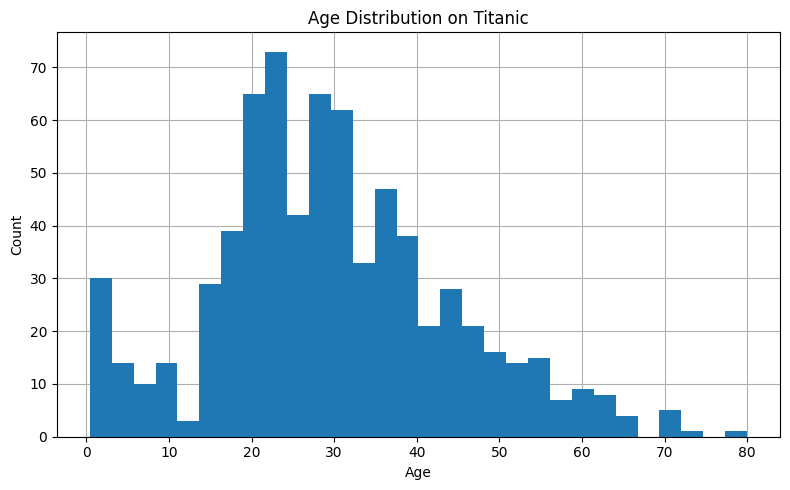

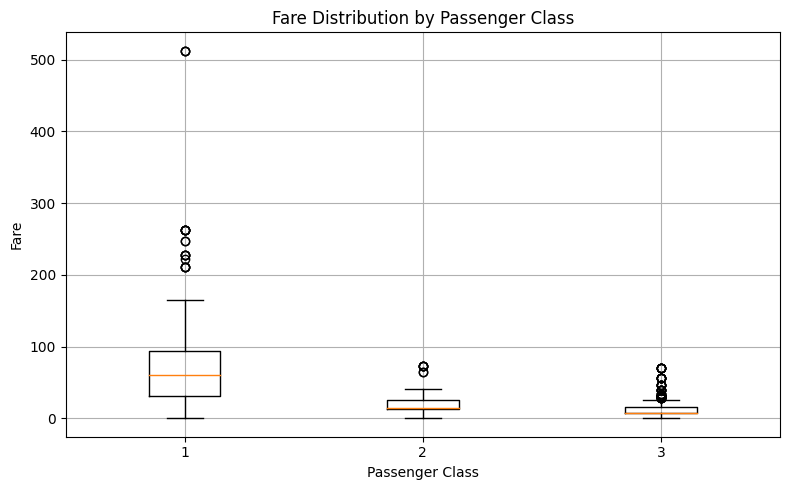

In [8]:
# train['Age'].hist(bins=30, figsize=(3,4)) 
# train.boxplot('Fare', by='Pclass', figsize=(3,4))
import matplotlib.pyplot as plt

# 1) Age histogram with grid behind
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_axisbelow(True)            # draw grid below other artists
ax.hist(train['Age'].dropna(), bins=30, zorder=2)  
ax.grid(True, zorder=1)           # grid lines at zorder=1
ax.set_title('Age Distribution on Titanic')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
fig.tight_layout()
plt.show()


# 2) Fare by Pclass boxplot with grid behind
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_axisbelow(True)
groups = [train.loc[train['Pclass']==cls, 'Fare'].dropna()
          for cls in sorted(train['Pclass'].unique())]
ax.boxplot(groups, labels=sorted(train['Pclass'].unique()), zorder=2)
ax.grid(True, zorder=1)
ax.set_title('Fare Distribution by Passenger Class')
ax.set_xlabel('Passenger Class')
ax.set_ylabel('Fare')
fig.tight_layout()
plt.show()


# Baseline

In [9]:
# 1) Auto-detect
all_num = train.select_dtypes(include=[np.number]).columns
all_cat = train.select_dtypes(include=['object','category']).columns

# 2) Remove target & IDs
num_cols = [c for c in all_num if c not in ('Survived','PassengerId')]
cat_cols = [c for c in all_cat]  # adjust if you have object IDs here

preproc = make_preprocessor(num_cols, cat_cols)
model_defs = {
    'LogReg': {
        'preproc': preproc,
        'clf':     LogisticRegression(max_iter=1000, random_state=42)
    },
    'RF': {
        'preproc': preproc,
        'clf':     RandomForestClassifier(n_jobs=-1, random_state=42)
    },
    'GB': {
        'preproc': preproc,
        'clf':     GradientBoostingClassifier(random_state=42)
    },
    'SVM': {
        'preproc': preproc,
        'clf':     SVC(random_state=42)
    },
}

X = train[num_cols + cat_cols]
y = train['Survived']

baseline_scores = compare_models(model_defs, X, y)

print(baseline_scores)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarn

SVM       0.824914
RF        0.820470
GB        0.814826
LogReg    0.809190
dtype: float64


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarn

# Engineer the new features & split

In [10]:
# 1) Extract the title in one shot using regex
pattern = r',\s*([^\.]+)\.'
for df in (train, test):
    df['Title'] = df['Name'].str.extract(pattern, expand=False)

# 2) Map rare titles into “Other”
common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
for df in (train, test):
    df['Title'] = df['Title'].where(df['Title'].isin(common_titles), 'Other')

# 1.b) FamilySize & IsAlone
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['IsAlone']    = (train['FamilySize']==1).astype(int)

# 1.c) Deck
train['Deck'] = train['Cabin'].fillna('M').str[0]

# 1.d) FareBin (quartiles)
train['FareBin'] = pd.qcut(train['Fare'], 4, labels=False, duplicates='drop')

# 1.e) AgeBin
age_edges  = [0,12,20,40,60,80]
age_labels = ['Child','Teen','Adult','MidAge','Senior']
train['AgeBin'] = pd.cut(
    train['Age'].fillna(train['Age'].median()),
    bins=age_edges, labels=age_labels
)

# 2) =========================
#    Define updated feature lists
NUM_COLS = ['Age','Fare','FamilySize']
CAT_COLS = ['Pclass','Sex','Embarked',
            'Title','IsAlone','Deck','FareBin','AgeBin']
TARGET   = 'Survived'

# 3) =========================
#    Hold out validation set
X = train[NUM_COLS + CAT_COLS]
y = train[TARGET]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 4) =========================
#    Build & fit your shared preprocessor
preprocessor = make_preprocessor(NUM_COLS, CAT_COLS)

# fit on train, transform both
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)

# now X_train_proc / X_val_proc are ready for any model:
#   e.g. LogisticRegression().fit(X_train_proc, y_train)


# CAT COL heatmap

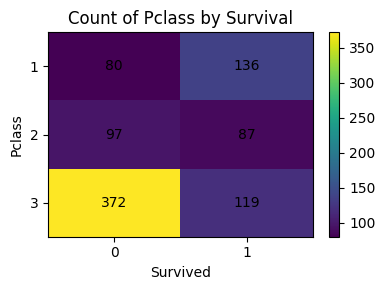

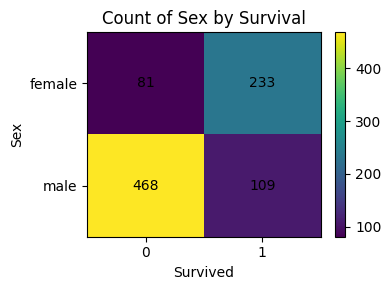

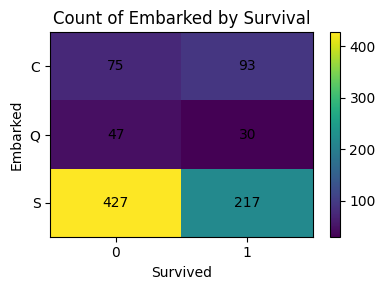

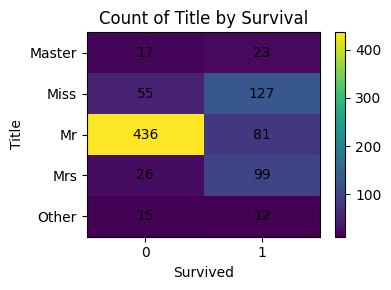

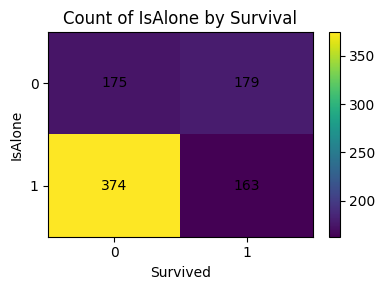

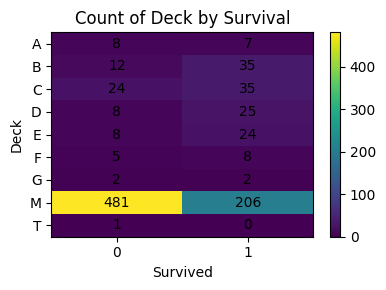

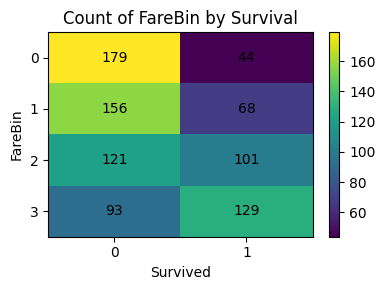

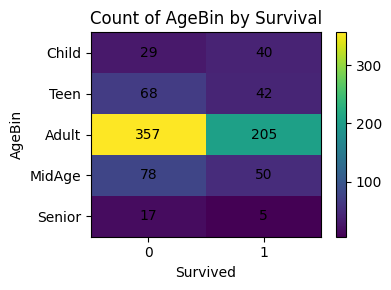

In [11]:
# 2. Loop & plot
for col in CAT_COLS:
    counts = pd.crosstab(train[col], train['Survived'])
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_axisbelow(True)               # grid behind
    im = ax.imshow(counts.values, aspect='auto', interpolation='nearest')
    
    # ticks and labels
    ax.set_xticks(range(counts.shape[1]))
    ax.set_xticklabels(counts.columns)
    ax.set_yticks(range(len(counts.index)))
    ax.set_yticklabels(counts.index)
    ax.set_xlabel('Survived')
    ax.set_ylabel(col)
    ax.set_title(f'Count of {col} by Survival')
    
    # annotate cell values
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            ax.text(j, i, counts.values[i, j], ha='center', va='center', zorder=3)
    
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


# PCA

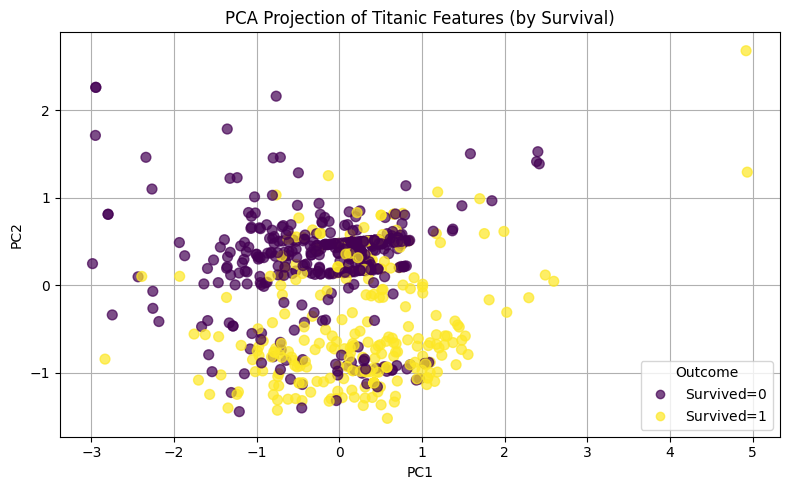

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# 1) Assuming you have your preprocessor and X_train_proc ready:
#    X_train_proc = preprocessor.fit_transform(X_train)
#    y_train       = y_train

# 2) Build a PCA pipeline (optional: you can combine preprocess + PCA in one)
pca_pipe = Pipeline([
    # ('preproc', preprocessor),       # your make_preprocessor(NUM_COLS, CAT_COLS)
    ('pca',     PCA(n_components=5, random_state=42))
])

# 3) Fit & transform
X_pca = pca_pipe.fit_transform(X_train_proc)

# 4) Plot the two principal components
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_axisbelow(True)
scatter = ax.scatter(
    X_pca[:, 2],
    X_pca[:, 3],
    c=y_train,
    s=50,
    alpha=0.7,
    cmap='viridis'
)
ax.set_title('PCA Projection of Titanic Features (by Survival)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')


handles, labels = scatter.legend_elements(
    prop="colors",
    alpha=0.7,
)
labels = [f"Survived={lab}" for lab in labels]

ax.legend(handles, labels, title="Outcome")
ax.grid(True)
plt.tight_layout()
plt.show()


#### add components 2 & 3 of PCA 

In [13]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer

select_pcs_2_3 = FunctionTransformer(lambda X: X[:, [2, 3]], validate=False)

union = FeatureUnion([
    ('orig_feats', preprocessor),
    ('pca23', Pipeline([
        ('prep', preprocessor),
        ('pca', PCA(n_components=5, random_state=42)),
        ('pick', select_pcs_2_3)
    ]))
])

# 3) Now plug that into a full pipeline with your classifier
pipe = Pipeline([
    ('features', union),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 4) Fit & score
pipe.fit(X_train, y_train)
print("Val accuracy:", pipe.score(X_val, y_val))

Val accuracy: 0.8044692737430168


# t-SNE

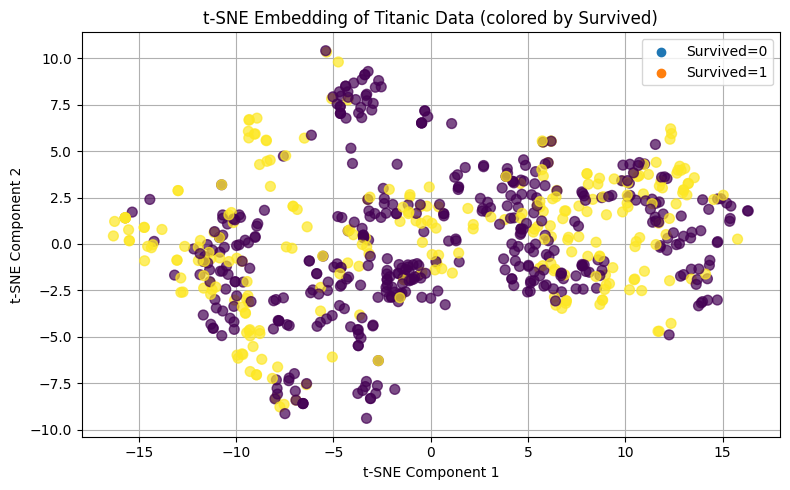

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_train_proc)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_axisbelow(True)
scatter = ax.scatter(
    X_tsne[:, 1],
    X_tsne[:, 2],
    c=y_train,
    s=50,
    alpha=0.7,cmap='viridis'
)
ax.set_title('t-SNE Embedding of Titanic Data (colored by Survived)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')

# Build legend manually
for label in sorted(y_train.unique()):
    ax.scatter([], [], label=f'Survived={label}')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# Baseline Model with new features

In [15]:
from sklearn.model_selection import cross_val_score

models = {
  "LogReg" : LogisticRegression(max_iter=1_000, random_state=42),
  "RF"     : RandomForestClassifier(n_estimators=100, random_state=42),
  "GradientBoosting": GradientBoostingClassifier(random_state=42),
  "SVM": SVC(random_state=42)}

scores = {}
for name, clf in models.items():
    cv_scores = cross_val_score(
        clf,
        X_train_proc,  # already preprocessed
        y_train,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    scores[name] = cv_scores.mean()

import pandas as pd
print(pd.Series(scores).sort_values(ascending=False))


GradientBoosting    0.823146
SVM                 0.820260
LogReg              0.817512
RF                  0.800660
dtype: float64


In [16]:
from common.pipelines     import compare_models
from common.preprocessing import make_preprocessor


# Hyperparameter tuning

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model      import LogisticRegression
from sklearn.ensemble          import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm               import SVC

# we’ll reuse the same preprocessor you already built:
preproc = make_preprocessor(NUM_COLS, CAT_COLS)

# wrap each model into a single Pipeline
pipelines = {
    "LogReg": Pipeline([
        ("preproc", preproc),
        ("clf",     LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "RF": Pipeline([
        ("preproc", preproc),
        ("clf",     RandomForestClassifier(n_jobs=-1, random_state=42))
    ]),
    "GB": Pipeline([
        ("preproc", preproc),
        ("clf",     GradientBoostingClassifier(random_state=42))
    ]),
    "SVM": Pipeline([
        ("preproc", preproc),
        ("clf",     SVC(random_state=42))
    ]),
}

param_grids = {
    "LogReg": {
        "clf__C":       [0.01, 0.1, 1, 10],
        "clf__solver": ["liblinear", "saga"],
        "clf__penalty": ["l2"],
    },
    "RF": {
        "clf__n_estimators": [100, 300],
        "clf__max_depth":    [None, 5, 10],
        "clf__min_samples_leaf": [1, 3],
    },
    "GB": {
        "clf__n_estimators": [100, 200],
        "clf__learning_rate": [0.01, 0.1],
        "clf__max_depth":    [3, 5],
    },
    "SVM": {
        "clf__C":     [0.1, 1, 10],
        "clf__kernel": ["rbf", "linear"],
        "clf__gamma": ["scale", "auto"],
    },
}
from sklearn.model_selection import cross_val_score

best_scores = {}
best_params = {}

for name, pipe in pipelines.items():
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best_scores[name] = grid.best_score_
    best_params[name] = grid.best_params_
    print(f"{name:>8} →  cv-accuracy = {grid.best_score_:.4f}")
    print(" " * 12, "best params:", grid.best_params_)

results = pd.DataFrame({
    "baseline_acc": baseline_scores,  # from your original compare_models run
    "tuned_acc":    best_scores,
}).T
print(results)



Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

  LogReg →  cv-accuracy = 0.8189
             best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

      RF →  cv-accuracy = 0.8329
             best params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 100}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

      GB →  cv-accuracy = 0.8231
             best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

     SVM →  cv-accuracy = 0.8245
             best params: {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
                    GB    LogReg        RF       SVM
baseline_acc  0.814826  0.809190  0.820470  0.824914
tuned_acc     0.823146  0.818891  0.832936  0.824485


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Validate & Report

In [21]:
best_model = grid.best_estimator_
val_preds = best_model.predict(X_val)
print("Val Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))


Val Accuracy: 0.8212290502793296
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.79      0.72      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



# Final Fit & Submission

In [24]:
# # retrain on full training data
# best_model.fit(train[NUM_COLS + CAT_COLS], train[TARGET])

# # predict test set
# submission = pd.DataFrame({
#     'PassengerId': test['PassengerId'],
#     'Survived':    best_model.predict(test[NUM_COLS + CAT_COLS])
# })
# submission.to_csv('submission.csv', index=False)


# Improve the model

In [ ]:
# PLAN

# More advanced encoding

# Try target encoding (mean-encode) for high-cardinality cats like Ticket prefix.
# For ordinal features (e.g. Pclass), use OrdinalEncoder instead of one-hot.
# Consider embedding age/fare as splines or polynomial features.

# Get fancier with your RF

# RandomizedSearchCV or BayesSearchCV (from scikit-optimize) to explore larger hyper-spaces more efficiently.
# Push n_estimators up into the thousands (RF loves more trees).
# Tune max_features (sqrt vs log2 vs a custom fraction).
# Play with bootstrap=False, min_samples_split, min_samples_leaf more aggressively.

# Try gradient-boosting libraries

# Often you’ll beat vanilla sklearn.GradientBoostingClassifier by switching to one of the popular libraries:

# XGBoost (xgboost.XGBClassifier)
# LightGBM (lightgbm.LGBMClassifier)
# CatBoost (catboost.CatBoostClassifier) — especially good on small data with categorical features
# They tend to give an extra 1–2% accuracy with minimal fuss.

# 6) Ensembling & stacking

# Once you have several “well-tuned” models:

# Stacking: Use a simple meta-learner (e.g. LogisticRegression) on the out-of-fold predictions of your RF, GBM, SVM, etc.
# VotingClassifier: Hard- or soft-vote across your top 3–5 models.
# Blending: Hold out a small validation set to blend your models’ probabilities.

# 7) Rigorous validation

# Switch to stratified K-fold cross-val (if you aren’t already).
# Track learning curves (train vs val score vs n_samples) to see if you’re overfitting or hungry for more data.
# Monitor feature importances (or SHAP values) to prune unhelpful features.